In [7]:
import cv2
import matplotlib.pyplot as plt

from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import  downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr, draw_parallel_lines



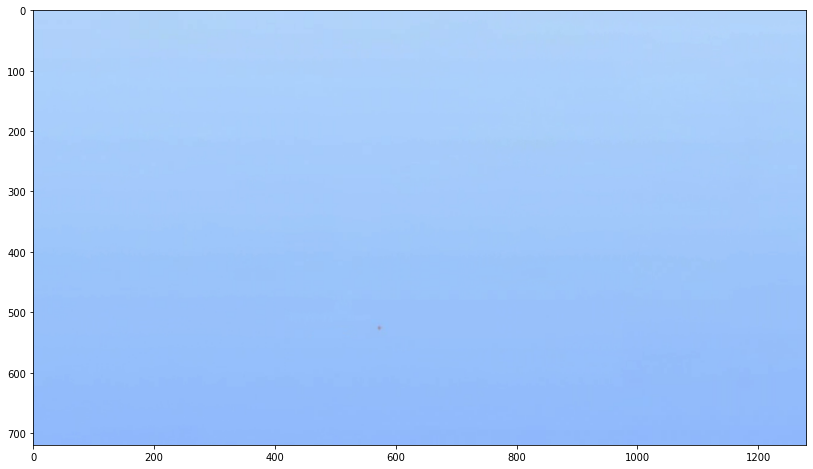

In [8]:
base_image_name = "horizon_2"
cap = cv2.VideoCapture(f"synth_videos/{base_image_name}/synth_track_video.mp4")

# Set the frame position (0-based index)
frame_index = 59
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

# Read the frame
ret, raw_frame = cap.read()
show_bgr(raw_frame,w=14)

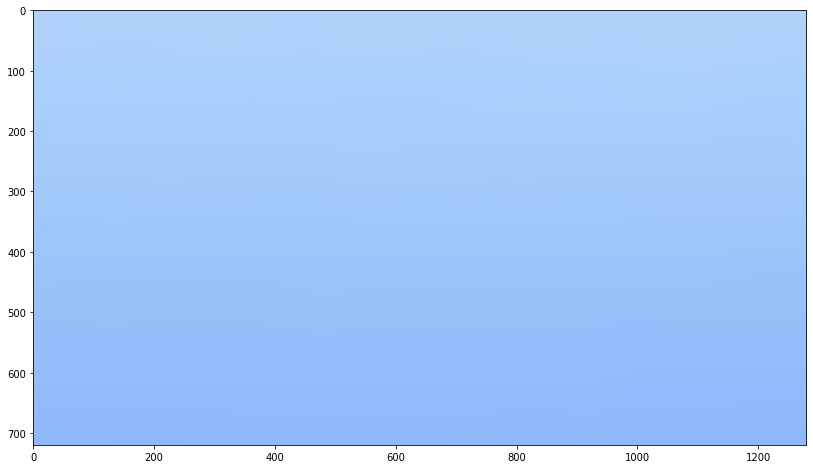

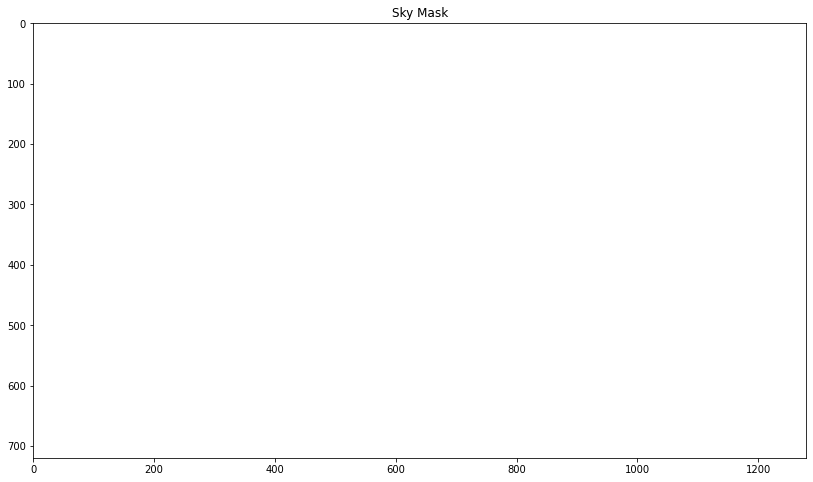

In [9]:
# Cell [3]: Sky Detection

#apply gaussian blur to the raw frame before passing to sky detector
blurred_frame = cv2.GaussianBlur(raw_frame, (125, 125), 125)
show_bgr(blurred_frame,w=14)
sky_mask = detect_sky(blurred_frame)  # user-defined function
show_bgr(sky_mask,w=14, title="Sky Mask")


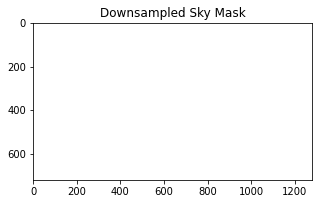

Horizon slope: 0, intercept: 720


In [13]:
# Cell [4]: Downsample & Estimate Horizon

scale_factor = 1
downsampled_sky_mask = downsampler(sky_mask, scale_factor=scale_factor)

# Estimate slope & intercept of the horizon
horizon_result = estimate_horizon_line_by_edges(downsampled_sky_mask)

if horizon_result is None:
    # Fallback if horizon detection fails
    print("Warning: Horizon detection failed. Using default horizon.")
    slope, intercept = 0, downsampled_sky_mask.shape[0]
    horizon_search_offset = 1
else:
    slope, intercept = horizon_result
    horizon_search_offset = 50

show_bgr(downsampled_sky_mask, title="Downsampled Sky Mask")
print(f"Horizon slope: {slope}, intercept: {intercept}")


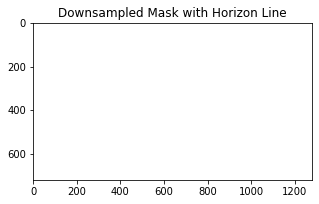

In [14]:
# Cell [5]: Draw Horizon on Downsampled

# For visualization
height_down, width_down = downsampled_sky_mask.shape[:2]
x_start, x_end = 0, width_down - 1

y_start = int(slope * x_start + intercept)
y_end   = int(slope * x_end   + intercept)

downsampled_sky_mask_horizon = downsampled_sky_mask.copy()
cv2.line(
    downsampled_sky_mask_horizon, 
    (x_start, y_start), 
    (x_end,   y_end),
    (0, 0, 255),
    1
)

show_bgr(downsampled_sky_mask_horizon, title="Downsampled Mask with Horizon Line")


Blue sky ratio: 0.0
Red sky ratio: 1.0


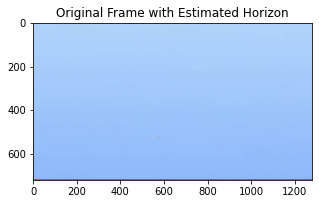

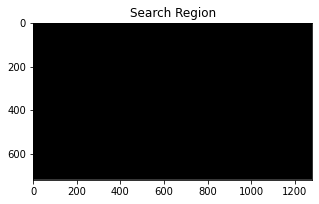

0


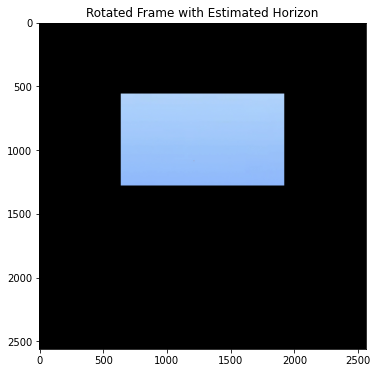

In [15]:
# Cell [6]: Draw Horizon on Original

annotated_image = raw_frame.copy()

cv2.line(
    annotated_image,
    (x_start * scale_factor, y_start * scale_factor),
    (x_end   * scale_factor, y_end   * scale_factor),
    (0, 0, 255),
    5
)

#show_bgr(annotated_image, title="Original Frame with Estimated Horizon")

double_line, region_mask, upside_down =  draw_parallel_lines(annotated_image,sky_mask, slope, intercept* scale_factor, distance=horizon_search_offset)

show_bgr(double_line, title="Original Frame with Estimated Horizon")
show_bgr(region_mask, title="Search Region")

print(slope)
rotated = rotate_and_center_horizon(raw_frame, slope, intercept* scale_factor, upside_down=upside_down)
show_bgr(rotated, title="Rotated Frame with Estimated Horizon",w=10)




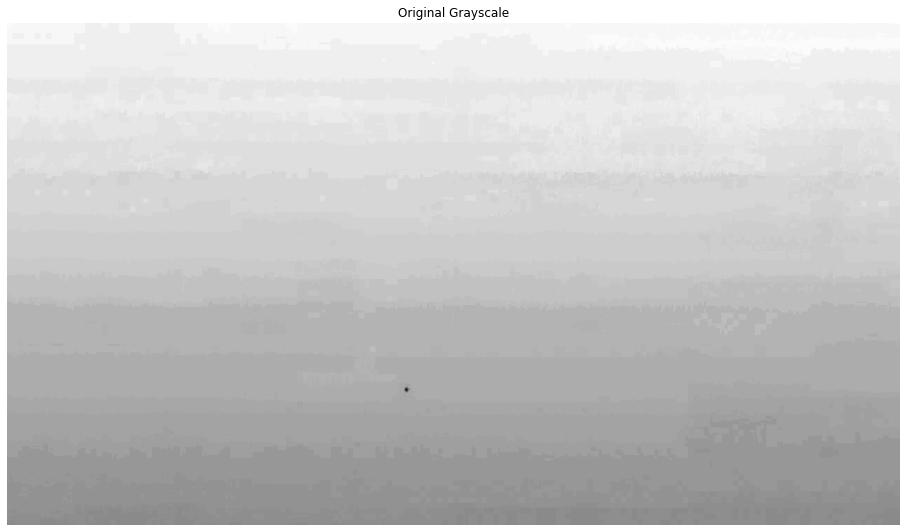

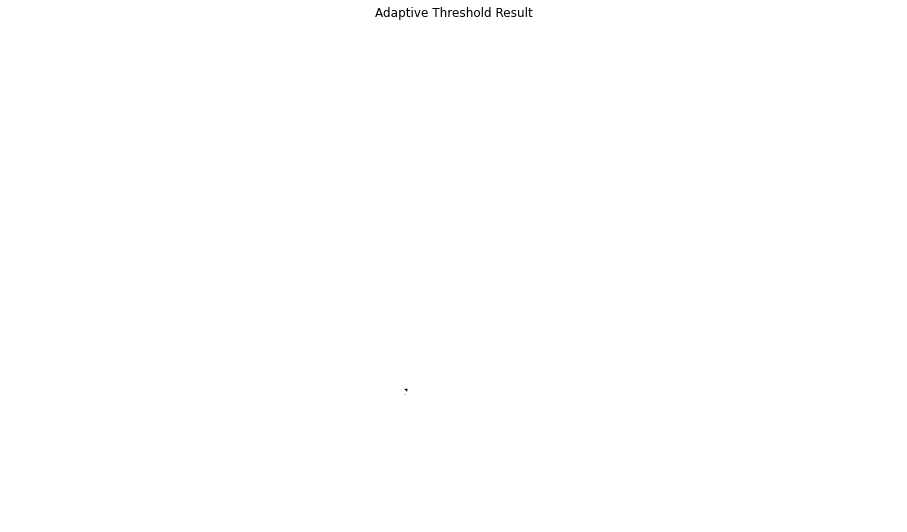

In [16]:
def show_gray(image, title=""):
    """Helper function to display a grayscale image with matplotlib."""
    plt.figure(figsize=(16, 14))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Read an image (can be color or already grayscale)
input_image = raw_frame
# Convert to grayscale if needed
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Adaptive Threshold
# - maxValue = 255
# - adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C (or cv2.ADAPTIVE_THRESH_MEAN_C)
# - thresholdType = cv2.THRESH_BINARY
# - blockSize = 11 (size of neighborhood, must be odd)
# - C = 2 (constant subtracted from the mean or weighted mean)
adaptive_thresh = cv2.adaptiveThreshold(
    gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=5,
    C=4
)

# Display
show_gray(gray, "Original Grayscale")
show_gray(adaptive_thresh, "Adaptive Threshold Result")

# remove_sky_band_distance(
#     sky_mask, 
#     slope, 
#     intercept, 
#     dist_threshold, 
#     reference_sky_pixel=None)

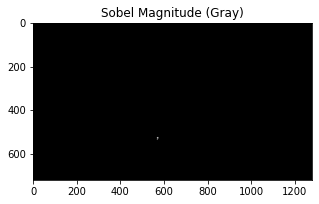

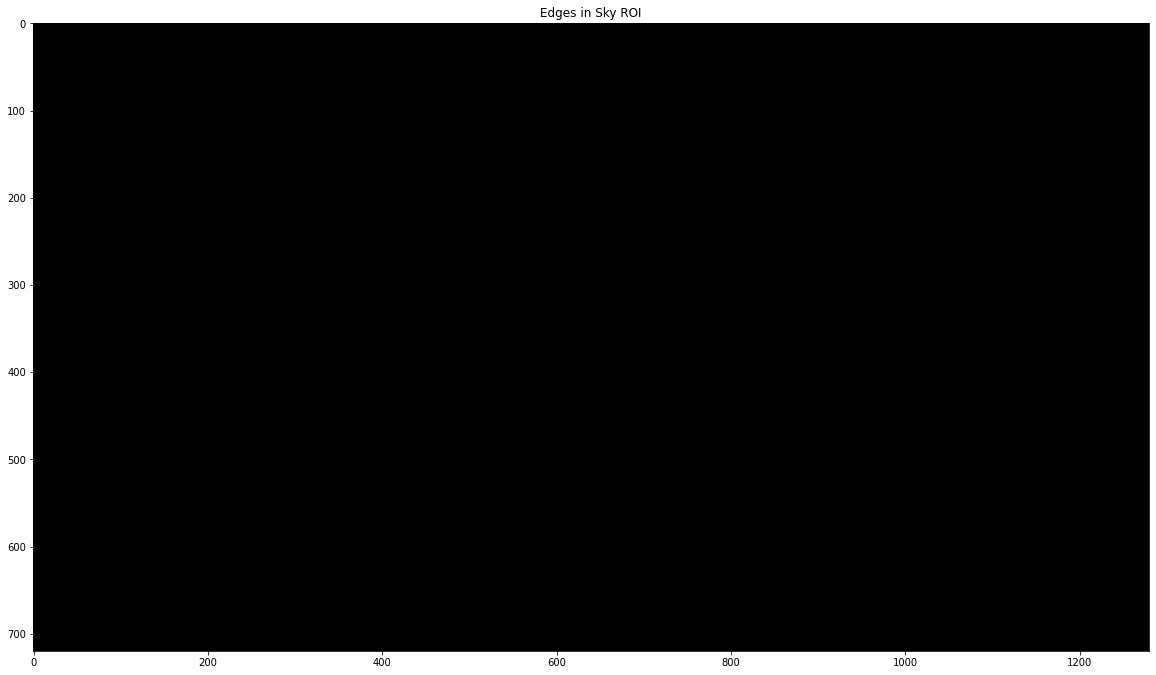

In [8]:
# Cell [9]: Sobel Edges in Sky ROI

gray_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2GRAY)

# Apply some Gaussian Blur
gaussian_blur_ksize = (3, 3)
gaussian_sigma = 0.5
blurred_gray = cv2.GaussianBlur(adaptive_thresh, gaussian_blur_ksize, gaussian_sigma)

# Sobel
sobel_x = cv2.Sobel(blurred_gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = cv2.magnitude(sobel_x, sobel_y)
sobel_abs = cv2.convertScaleAbs(sobel_mag)

# Threshold
sobel_threshold = 50
_, sobel_mask = cv2.threshold(sobel_abs, sobel_threshold, 255, cv2.THRESH_BINARY)

# Restrict edges to sky ROI
edges_in_sky_roi = cv2.bitwise_and(sobel_mask, region_mask)

show_bgr(sobel_abs, title="Sobel Magnitude (Gray)")
show_bgr(edges_in_sky_roi, w=20,title="Edges in Sky ROI")



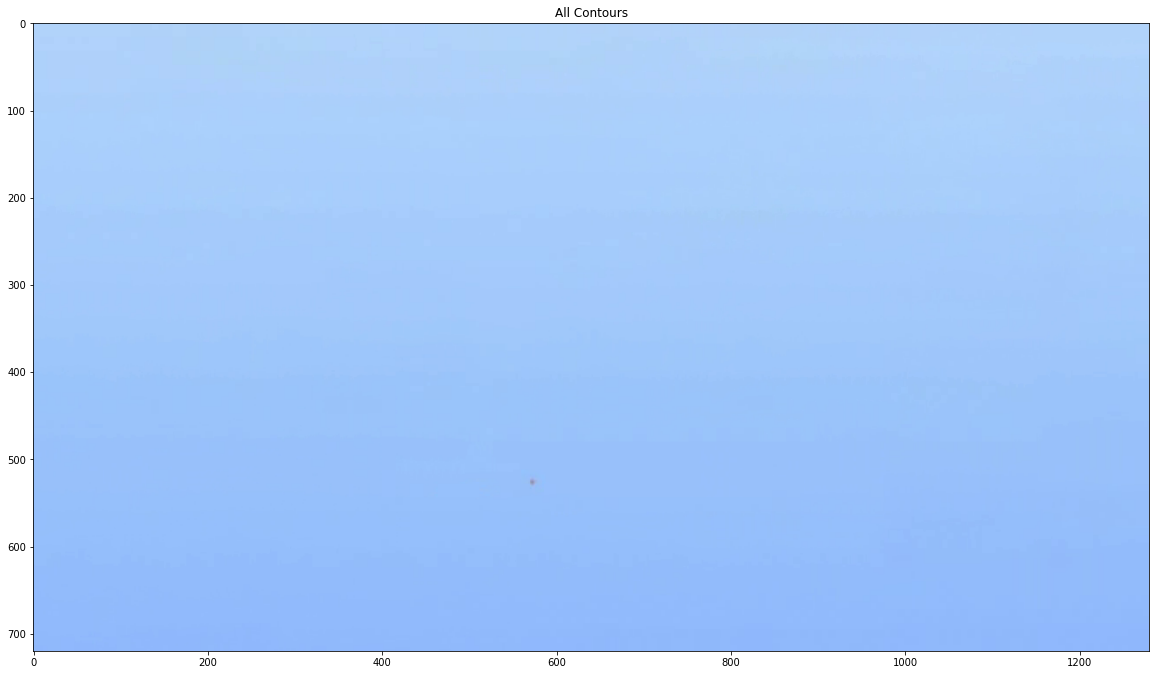

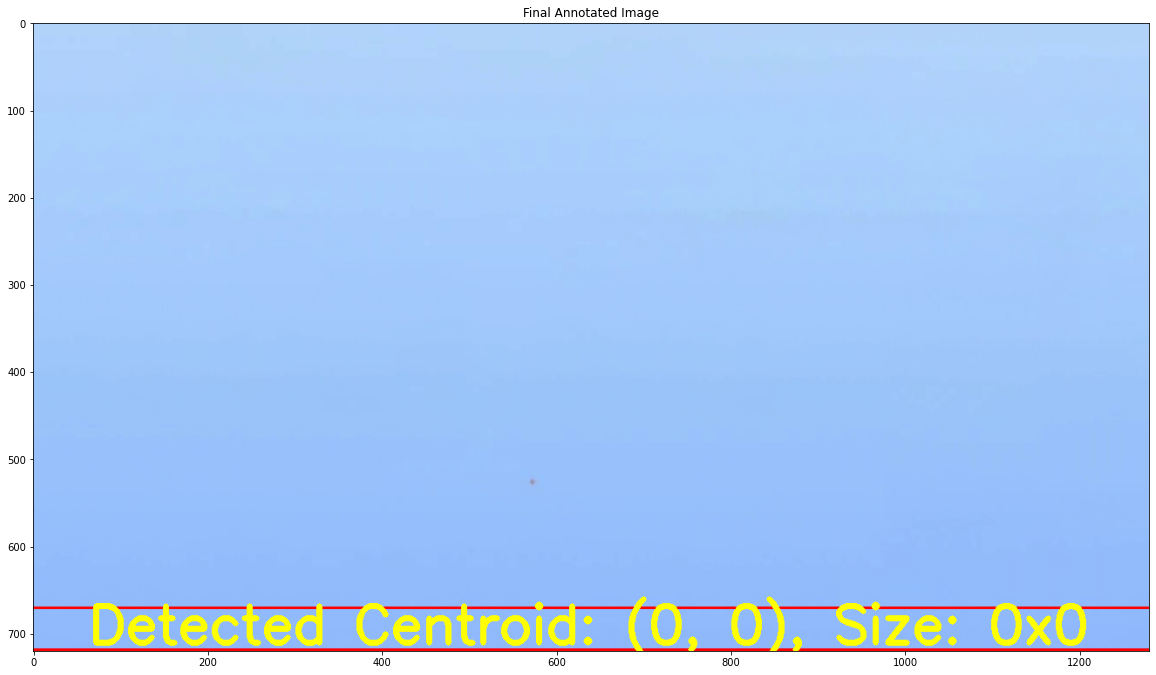

Centroid = (0, 0),  BoundingBox = 0 x 0


In [9]:
# Cell [10]: Find Largest Contour & Annotate

#contours, _ = cv2.findContours(edges_in_sky_roi[0:int(edges_in_sky_roi.shape[0]*.95),0:int(edges_in_sky_roi.shape[1]*.95)], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(edges_in_sky_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#draw all contours on a copy of the original image
contour_image = raw_frame.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
show_bgr(contour_image, title="All Contours",w=20)



annotated_final = annotated_image.copy()
cx, cy, bw, bh = 0, 0, 0, 0  # defaults

#### Add size and color bounds on contours

if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx = x + w // 2
        cy = y + h // 2
    
    bw, bh = w, h
    
    # Draw bounding box & annotation
    cv2.rectangle(annotated_final, (x, y), (x + w, y + h), (0, 255, 0), 4)
    text_str = f"Detected Centroid: ({cx}, {cy}), Size: {w}x{h}"
    annotate_image(annotated_final, text_str)
else:
    text_str = "Detected Centroid: (0, 0), Size: 0x0"
    annotate_image(annotated_final, text_str)

show_bgr(annotated_final,w=20, title="Final Annotated Image")

print(f"Centroid = ({cx}, {cy}),  BoundingBox = {bw} x {bh}")
